# Clustering data using scikit-learn

source: https://developer.ibm.com/technologies/data-science/tutorials/learn-clustering-algorithms-using-python-and-scikit-learn/

Clustering algorithms allow you to automatically find ways to group multidimentional data into clusters.

In this notebook, we'll use scikit-learn to predict clusters. 
scikit-learn provides implementations of many clustering algorithms.
As we experiment with each clustering algorithm, you'll see some of the advantages and drawbacks of each one.
The following algorithms are demonstrated in this notebook:


The algorithms we use fall into three different categories:

- Centroid-based clustering (k-means and Mean shift)
- Density-based clustering (DBSCAN)
- Hierarchical clustering (Agglomerative clustering)


| Category | Algorithm | Description |
| --- | --- | --- |
| Centroid-based | k-means | Find a predetermined number (k) of center points to create k clusters based on distance from center. |
| Centroid-based | mean shift | Seek areas of higher density to determine cluster centers. |
| Density-based | DBSCAN | Separate out the noise (points in sparse regions) and group together data in dense regions. |
| Hierarchical | agglomerative clustering | Start with each point as its own cluster and then merge the nearest cluster until the goal is reached. |


## Imports

Import the python modules that we need in the rest of the notebook.

In [1]:
%matplotlib inline
from time import sleep
from IPython.display import display, clear_output
import matplotlib as mpl
import matplotlib.animation
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib import lines
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from sklearn.cluster import estimate_bandwidth
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons

## Setup
To help visualize what we are doing, we'll use 3D charts to show how the clustering looks (with 3 selected dimensions) with two of the most popular Python visualization tools:

* matplotlib enhanced with seaborn styling and animation
* Plotly for a more interactive view (e.g., zoom and rotate a 3D chart with your mouse)

> NOTE!  You Need to install plotly, if you don't have it just # it


pip install --user plotly

## Setup visualization

Configure seaborn to enhance our matplotlib charts.

In [3]:
sns.set(style='darkgrid')
plt.rcParams['figure.figsize'] = [8, 3]

Define some functions that will be used repeatedly for visualization.

In [4]:
# 3D matplotlib (plus seaborn) charting with some data prep and optional center points
def show_scatter_3d(df, x_name, y_name, z_name, predicted=None, centers=None,
                    marker='o', cmap=None, edgecolors=None, alpha=0.3,
                    elev=25, azim=10, show_colorbar=True,
                    xlim3d=None, ylim3d=None, zlim3d=None):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    x_index = df.columns.get_loc(x_name)
    y_index = df.columns.get_loc(y_name)
    z_index = df.columns.get_loc(z_name)
    
    x = df[x_name]
    y = df[y_name]
    z = df[z_name]

    if centers is not None:
        spot_size=15  # Smaller spots make X more visible
        for center in centers:
            if center is not None:
                ax.scatter(center[x_index], center[y_index], center[z_index], marker="X", s=500, color='red')
    else:
        spot_size=30

    # Pass in cmap if necessary, else get a right-sized list here
    if not cmap:
        cmap = ListedColormap(sns.color_palette("Set2",len(set(predicted))))
    
    chart = ax.scatter(x, y, z, c=predicted, marker=marker, edgecolors=edgecolors, cmap=cmap, s=spot_size, alpha=alpha)
    
    # Add axis labels
    ax.set_xlabel(x_name)
    ax.set_ylabel(y_name)
    ax.set_zlabel(z_name)
    
    # Optionally, set the axis limits:
    if xlim3d:
        ax.set_xlim3d(xlim3d)
    if ylim3d:
        ax.set_ylim3d(ylim3d)
    if zlim3d:
        ax.set_zlim3d(zlim3d)

    # Make room for axis titles
    plt.subplots_adjust(bottom=1, top=3, left=0, right=2)
    
    # Chart rotation
    ax.view_init(elev, azim)
    
    if show_colorbar:
        fig.colorbar(chart, ticks=list(set(predicted)))
    
    return fig, ax  

In [5]:
RdYlBu = plt.get_cmap('RdYlBu')  # colormap for moons

def show_scatter_moons(data, prediction, centers=[]):
    plt.scatter(data[:, 0], data[:, 1], c=prediction, cmap=RdYlBu, alpha=0.5);
    for center in centers:
        plt.scatter(center[0], center[1], marker="X", s=300, color='red')        

In [6]:
# Plotly 3D scatter chart is almost a one-liner, but use this function to keep the params in one place
def plotly_scatter_3d(df, x, y, z, color=None):
    fig = px.scatter_3d(df, x=x, y=y, z=z, color=color,
                    opacity=0.2, template='plotly_dark', color_continuous_scale=px.colors.qualitative.Set1)
    fig.show()   

In [7]:
# Use a stacked bar chart for an external evaluation of the churn cluster vs known churn risk

# Map the risk values to sortables (and still OK for the legend)
risk_map = {'High': '2: High', 'Medium': '1: Medium', 'Low': '0: Low'}
    
# Reusable chart to see if our clusters might help with churn risk prediction
def show_risk_by_cluster(data, risk):
    
    # Create DataFrame with predicted CLUSTER ID
    data_df = pd.DataFrame(data=data, columns=['CLUSTER'])
    
    # Add CHURN_RISK using sortable values
    data_df['CHURN_RISK'] = risk.map(risk_map)
    
    # Group by and count to get count of Hi/Med/Low in each cluster
    grouped_data = data_df.groupby(['CLUSTER', 'CHURN_RISK']).size().to_frame().reset_index()
    
    # Pivot for charting
    pivot = grouped_data.pivot(index='CLUSTER', columns='CHURN_RISK', values=0).fillna(0)
    
    # Sort to show descending High and then ascending Low counts
    pivot = pivot.reindex(pivot.sort_values(by=['2: High', '0: Low'], ascending=[False, True]).index)

    # Plot the sorted stacked bar chart
    pivot.plot(kind='bar', stacked=True, color='gbr')

    # Put the legend on the side    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) 

## k-means clustering
Let’s start with k-means clustering. k-means is often used as the “Hello World” of clustering algortithms. The “k” stands for the number of clusters (or cluster centers). To use k-means, you must set “k.” This is one of the big weaknesses of k-means. Of course, you could write a loop and evaluate different settings of k, but you’ll see other algorithms that won’t make you do that.

Our first example uses the data set that was generated with scikit-learn’s make_blobs() function. We created three discrete blobs that are easy for k-means to predict when k=3. We actually created ten-dimensional hyperspheres! But k-means has no problem with the extra dimensions. We pick three dimensions when we show the blobs in a 3-D matplotlib (plus seaborn) chart.

The following code trains a k-means model and runs prediction on the data set. The chart uses color to show the predicted cluster membership and a red X to show the cluster center.

In [15]:
# Generate 10 features even though we generally only chart 3 (these are nice multidemensional, spherical clusters)
n_features = 10
n_samples = 1000
random_state = 100

# blobs is our generated data set.  blob_labels is the expected blob cluster membership.
blobs, blob_labels = make_blobs(n_samples=n_samples, n_features=n_features, random_state=random_state)

# Put the data set in a DataFrame and give it some columns names.
blobs_df = pd.DataFrame(blobs, columns=['X', 'Y', 'Z', 'A', 'B', 'C', 'D', 'E', 'F', 'G'])
blobs_df['CLUSTER'] = blob_labels

blobs_df.head()

,X,Y,Z,A,B,C,D,E,F,G,CLUSTER
0,5.736657,-5.495132,-6.225783,-7.679217,-5.675882,10.204134,6.499985,-6.153485,6.012104,-5.607725,1
1,6.856021,-3.128796,-5.362158,-8.365592,-5.891344,8.623532,8.743615,-7.107779,5.734039,-4.473739,1
2,-2.632855,8.364998,5.760151,-4.492198,-5.883384,-2.821694,-10.137816,-5.904026,5.706769,-10.675624,2
3,-0.929539,-5.094169,1.039638,5.257847,-9.899305,-7.026905,3.282882,6.138319,-5.325245,0.459992,0
4,7.974444,-6.290471,-7.347292,-7.390165,-7.305787,8.869790,6.115273,-7.500320,5.510690,-4.122081,1


Although we used 10 dimensions and only show 3, the generated hyperspheres are easy for the k-means algorithm to cluster as expected if you pick the correct number for clusters.  If you change `n_clusters`, you'll see that the clusters are combined or split in ways that might not make sense visually.

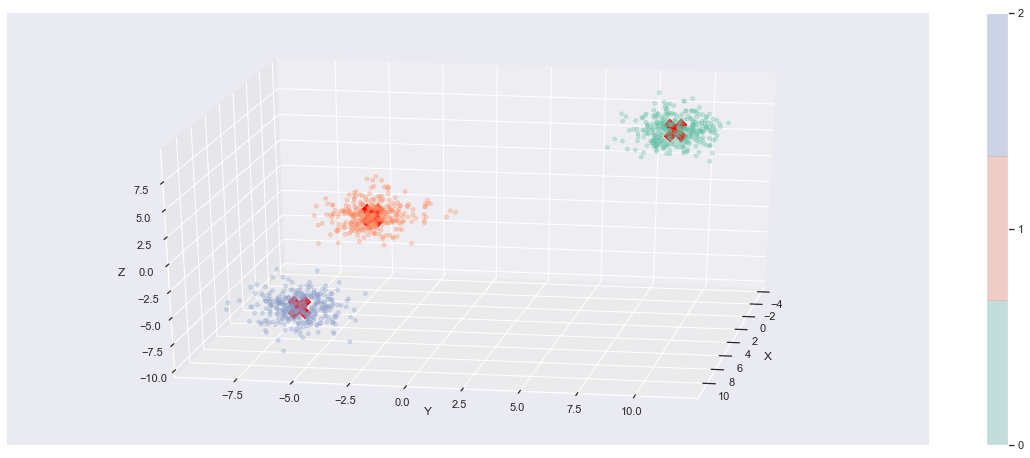

In [13]:
k = 3
kmeans = KMeans(n_clusters=k)
y_pred = kmeans.fit_predict(blobs)
centers = kmeans.cluster_centers_

show_scatter_3d(blobs_df, 'X', 'Y', 'Z',  predicted=y_pred, centers=centers);

### How does k-means work?
k-means starts by assigning k (three) cluster centroid seeds in the hyperspace. You could start with random points, but the scikit-learn default is a bit smarter. It puts some distance between the points to avoid randomly falling into the trap of converging on some local minimums. Another scikit-learn default (n_init=10) indicates that it will run ten times with different seeds, to make sure it did not get unlucky with some “bad seeds.”

Next, it computes the distance between every point and every cluster centroid, and assigns each point to the closest centroid. After the points are assigned, the mean values for each cluster of points are calculated. These mean values are used as the centroids in the next iteration. The assignment and re-centering process is repeated until no significant re-centering is needed.

### Limitations of k-means clustering
We mentioned earlier that you need to specify “k” (number of clusters). If you tried using a number other than 3 in our blobs example, you’ll have to divide or combine the blobs.

The second big limitation is that k-means separates the points into spherical shapes (or hyperspheres in hyperdimensions). To illustrate this, the next example in our Notebook uses scikit-learn’s make_moons() function to create a two-dimensional data set that looks like two crescent shapes, or a smile and a frown.

Visually, it is obvious that the data points form two shapes, and with k=2 you would like to see the predicted clusters separate the smile from the frown. Unfortunately, you cannot do that separation using spherical clusters.

##### k-means Moons

In [16]:
# 2-dimensional moons dataset to show where some algorithms excel.
moons, moon_labels = make_moons(n_samples=n_samples, noise=.05)

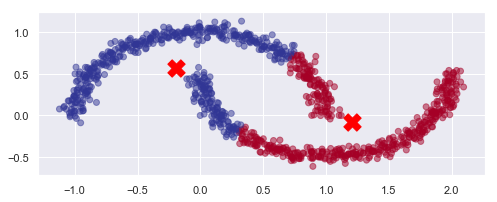

In [17]:
k = 2
kmeans = KMeans(n_clusters=k)
y_pred = kmeans.fit_predict(moons)
centers = kmeans.cluster_centers_
    
show_scatter_moons(moons, y_pred, centers)

To look at a less-contrived example, we’ve used part of a customer data set that includes customer demographics, account activity, and stock-trading profit. 

##### Prepare the customer data

Remove the CHURNRISK column. We don't want to use that label for clustering, but we will save it to try some external evaluation of our clusters later.

Select just a few numeric columns as features for our customer clusterer demos -- including gains minus losses combined into a single PROFIT_YTD.


In [18]:
df = pd.read_csv("data/mergedcustomers.csv")

In [19]:
# Save the CHURNRISK label column for later.
known_risk = df['CHURNRISK']

# Combine gains - losses into a profit column,
# and select a some of the numeric trader data to use for our customer clustering example.
keep_columns = ['AGE', 'TOTALUNITSTRADED', 'DAYSSINCELASTTRADE', 'DAYSSINCELASTLOGIN', 'PROFIT_YTD']

df_churn = df.assign(PROFIT_YTD=df.apply(lambda row: row.NETREALIZEDGAINS_YTD - row.NETREALIZEDLOSSES_YTD, axis=1).values)[keep_columns]


# Pick 3 features to use later in 3D charts
x_name = 'AGE'
y_name = 'PROFIT_YTD'
z_name = 'DAYSSINCELASTTRADE'

df_churn.head()

,AGE,TOTALUNITSTRADED,DAYSSINCELASTTRADE,DAYSSINCELASTLOGIN,PROFIT_YTD
0,47,58,13,2,-152.76525
1,25,13,10,4,1349.63500
2,42,28,5,4,1123.61250
3,52,36,6,3,-652.56550
4,40,8,9,4,-1496.14950


In [20]:
df_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2066 entries, 0 to 2065
Data columns (total 5 columns):
AGE                   2066 non-null int64
TOTALUNITSTRADED      2066 non-null int64
DAYSSINCELASTTRADE    2066 non-null int64
DAYSSINCELASTLOGIN    2066 non-null int64
PROFIT_YTD            2066 non-null float64
dtypes: float64(1), int64(4)
memory usage: 80.8 KB


before using k-means,  let's just use the labels for color

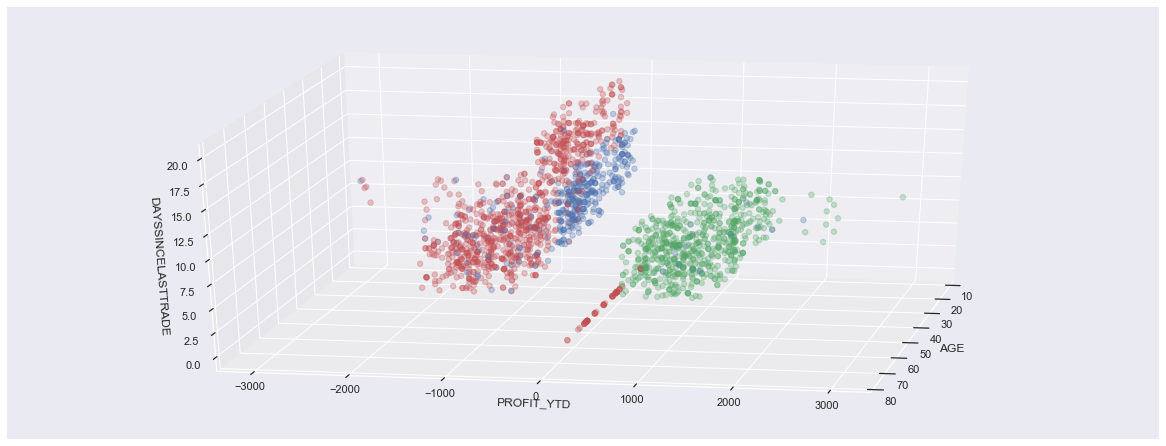

In [25]:
# We did not use k-means yet, let's just use the labels for color
label_colors = known_risk.map({'High': 'r', 'Medium': 'b', 'Low': 'g'})

show_scatter_3d(df_churn, x_name, y_name, z_name, predicted=label_colors, show_colorbar=False);

##### k-means clustering with our customer data

k-means cluster using our selected customer features looks OK visually. It certainly would be nice if the `n_clusters` was more automatic. We're using n_clusters=3 (and you can experiment).

One thing you might notice is that there are outlier data points or smaller clusters that don't look right. Adjusting n_clusters can help, but an algorithm that understands the concept of outliers would be more helpful.


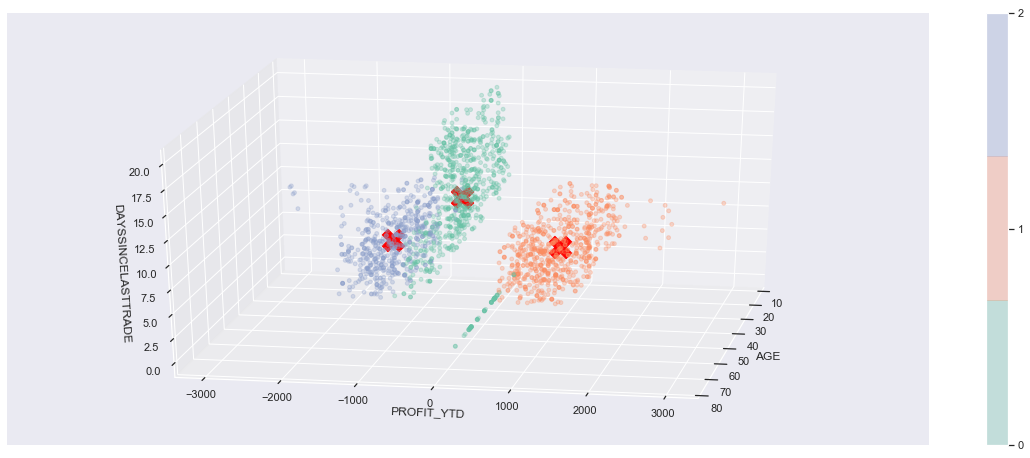

In [16]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters)
predicted = kmeans.fit_predict(df_churn.values)
centers = kmeans.cluster_centers_

show_scatter_3d(df_churn, x_name, y_name, z_name, predicted=predicted, centers=centers);

### External evaluation

We can do "external evaluation" by comparing the predicted clusters with the CHURNRISK label that we removed from the data.
You shouldn't expect unsupervised learning to be a good predictor of something so specific (supervised learning should work better),
but this demonstrates that these discovered customer groupings might have some things in common.

With n_clusters=3, you'll see that low risk customers were grouped pretty accurately. Another cluster is mostly high risk. The third group is high/medium.
You can run this again after predicting different numbers of clusters. Also, we'll see later how this compares to other algorithms.

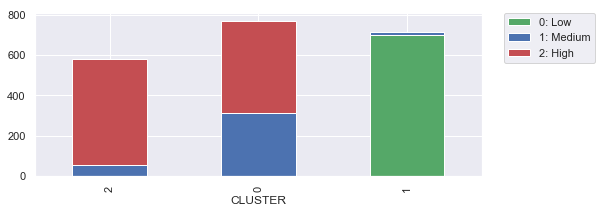

In [17]:
show_risk_by_cluster(predicted, known_risk)

#### Using Plotly

If you experimented above, you may have noticed that our k-means clusers were heavily influenced by the PROFIT_YTD column.
Using Plotly to rotate the chart and look at it from other angles can help you see that.


In [18]:
X_df = df_churn.copy()
X_df['CLUSTER'] = predicted
plotly_scatter_3d(X_df, x_name, y_name, z_name, color='CLUSTER')

## Mean shift

Mean shift is centroid-based like k-means, but has some advantages:

1. You don't need to specify n_clusters
2. It is not limited to hyperspheres
3. It recognizes density when seeking cluster centers
4. `cluster_all=False` allows orphans


##### k-means Moons
Because mean shift at least considers density, you might think it would handle the moons data set better than k-means, but actually, we had to customize the parameters quite a bit before it would recognize two clusters. Even then, you see that a centroid-based approach does not work well to separate the smile from the frown. Notice the long tails of orphans that we got with the cluster_all=False setting.

Number of clusters: 2
Number of outliers: 414


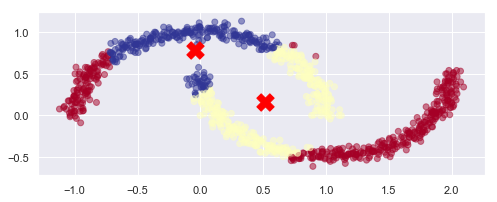

In [34]:
bandwidth = estimate_bandwidth(moons, quantile=.2, n_samples=1000) 
ms = MeanShift(cluster_all=False, bandwidth=bandwidth)
y_pred = ms.fit_predict(moons)
centers = ms.cluster_centers_
    
show_scatter_moons(moons, y_pred, centers)

print('Number of clusters:', len(set(y_pred)) - (1 if -1 in predicted else 0))
print('Number of outliers:', list(y_pred).count(-1))


##### MeanShift clustering with our customer data
Let’s look at the customer clusters that were predicted with mean shift. First, notice that we did not need to specify the number of clusters, and the algorithm chose five clusters. It’s great that you don’t need to predetermine that. Instead of forcing the data into k-clusters, the number of clusters was chosen to match the data.

Next, notice that we used the non-default cluster_all=False parameter setting. This allowed the algorithm to take data points in sparse regions and label them as orphans (cluster -1). In the chart, the sparse green points on the left and on the right were orphans. The animated matplotlib chart shows how separating the orphans adds clarity to the remaining clusters and also identifies data points that might be considered anomalies.

In [27]:
ms = MeanShift(cluster_all=False)
predicted = ms.fit_predict(df_churn.values)
labels = ms.labels_
centers = ms.cluster_centers_

print("Number of clusters: ", len(centers))

Number of clusters:  5


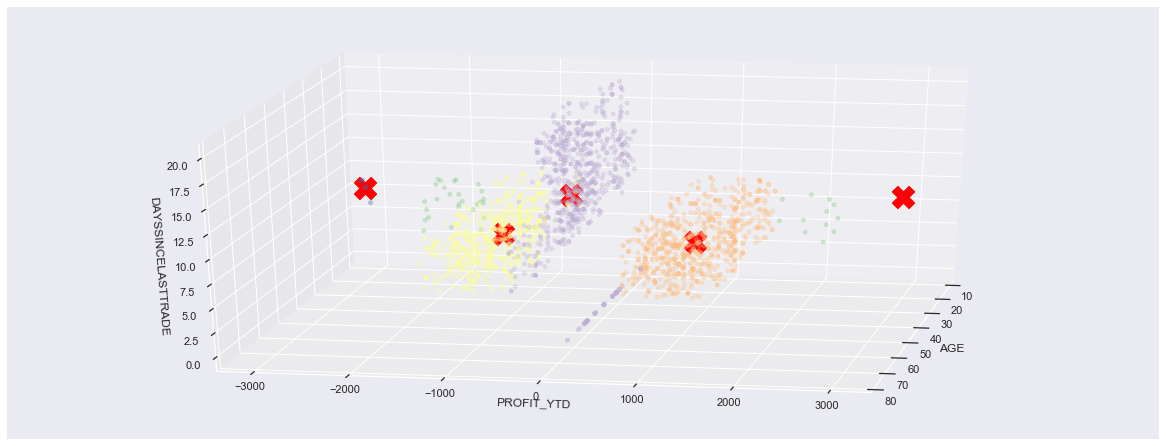

In [28]:
show_scatter_3d(df_churn, x_name, y_name, z_name, predicted=predicted, centers=centers,
                show_colorbar=False,
                cmap=ListedColormap(cm.Accent.colors[:6]));

With matplotlib animation we can cycle through charts that show the clusters and the orphans to help illustrate the separation accomplished by detecting sparse and dense regions.

In [29]:
temp_df = df_churn.copy()
temp_df['CLUSTER'] = predicted
no_outliers_df = temp_df[temp_df['CLUSTER']!=-1]
outliers_df = temp_df[temp_df['CLUSTER']==-1]

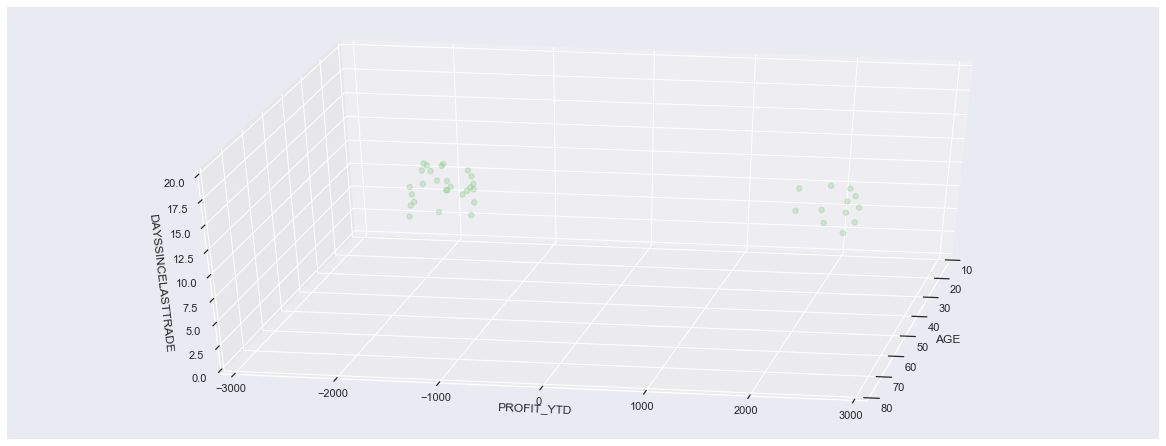

In [30]:
charts = [
    {'dataframe': temp_df, 'centers': centers, 'cmap': ListedColormap(cm.Accent.colors[:6])},
    {'dataframe': outliers_df, 'centers': centers, 'cmap': ListedColormap(cm.Accent.colors[:1])},
    {'dataframe': temp_df, 'centers': centers, 'cmap': ListedColormap(cm.Accent.colors[:6])},
    {'dataframe': no_outliers_df, 'centers': centers, 'cmap': ListedColormap(cm.Accent.colors[1:6])},
    {'dataframe': temp_df, 'centers': centers, 'cmap': ListedColormap(cm.Accent.colors[:6])},
    {'dataframe': no_outliers_df, 'centers': None, 'cmap': ListedColormap(cm.Accent.colors[1:6])},
    {'dataframe': temp_df, 'centers': None, 'cmap': ListedColormap(cm.Accent.colors[:6])},
    {'dataframe': no_outliers_df, 'centers': None, 'cmap': ListedColormap(cm.Accent.colors[1:6])},
    {'dataframe': temp_df, 'centers': None, 'cmap': ListedColormap(cm.Accent.colors[:6])},
    {'dataframe': outliers_df, 'centers': None, 'cmap': ListedColormap(cm.Accent.colors[:1])},
    {'dataframe': temp_df, 'centers': None, 'cmap': ListedColormap(cm.Accent.colors[:6])},
    {'dataframe': outliers_df, 'centers': None, 'cmap': ListedColormap(cm.Accent.colors[:1])}
]

# n loops for more time to watch charts
loops = 2
for loop in range(loops):
  for chart in charts:
    clear_output(wait=True)
    fig, ax = show_scatter_3d(chart['dataframe'], x_name, y_name, z_name, predicted=chart['dataframe']['CLUSTER'],
                centers=chart['centers'],
                show_colorbar=False, cmap=chart['cmap'],
                elev=35, azim=10,
                xlim3d=(10, 80), ylim3d=(-3000, 3000), zlim3d=(0, 20))
        
    display(fig)
    plt.close(fig)
    sleep(1)

When comparing to the risk label, it is not obvious if these groupings are significantly more useful than our original three (from k-means), but it would make sense that the orphans and the mini-clusters on the edges would be less likely to be consistent with the more densely clustered customers. Separating them helps clarify our groupings.

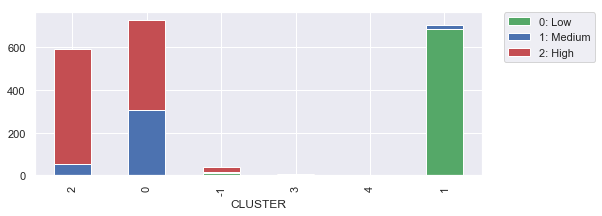

In [24]:
show_risk_by_cluster(predicted, known_risk)

## Density-Based Spatial Clustering of Applications with Noise (DBSCAN)

##### DBSCAN moons
Let’s get right to what DBSCAN can do that our centroid-based algorithms failed to do. DBSCAN separated the smile from the frown and also found three points to label as an outliers.

Number of clusters: 2
Number of outliers: 1


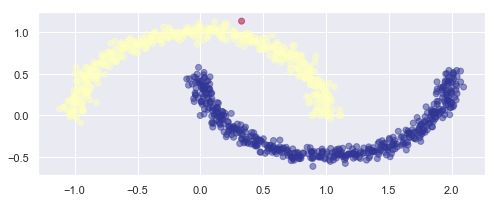

In [33]:
from sklearn.cluster import DBSCAN
predicted = DBSCAN(eps=.1).fit_predict(moons)

print('Number of clusters:', len(set(predicted)) - (1 if -1 in predicted else 0))
print('Number of outliers:', list(predicted).count(-1))

show_scatter_moons(moons, predicted)

 ##### How does DBSCAN work?
DBSCAN works by defining a cluster as the maximal set of density connected points. it Finds core samples of high density and expands clusters from them.
Based on a set of points, DBSCAN groups together points that are close to each other based on a distance measurement (usually Euclidean distance) and a minimum number of points. It also marks as outliers the points that are in low-density regions.

The DBSCAN algorithm basically requires 2 parameters:

- `eps`: specifies how close points should be to each other to be considered a part of a cluster. It means that if the distance between two points is lower or equal to this value (eps), these points are considered neighbors.
- `min_samples`: the minimum number of points to form a dense region. For example, if we set the min_samples parameter as 5, then we need at least 5 points to form a dense region.

There are three classifications of points: core, border, and outlier. A core point has at least minimum samples within its epsilon neighborhood including itself. These are points that are at the interior of a cluster. A border point has less than minimum points within its epsilon neighborhood but can be reached by the cluster. That is, it’s in the neighborhood of a core point. Finally, an outlier, or noise point, is a point that cannot be reached by a cluster.

good reference
https://www.kdnuggets.com/2020/04/dbscan-clustering-algorithm-machine-learning.html

##### Advantages of DBSCAN
The advantages of DBSCAN include:

- Automatically determining the number of clusters
- Identifying the outliers (noise)
- Not restricted to spherical clusters

##### DBSCAN customer clusterer without noise

In [36]:

predicted = DBSCAN(eps=110).fit_predict(df_churn)

print('Number of clusters:', len(set(predicted)) - (1 if -1 in predicted else 0))
print('Number of outliers:', list(predicted).count(-1))

Number of clusters: 6
Number of outliers: 23


In [37]:
temp_df = df_churn.copy()
temp_df['CLUSTER'] = predicted
temp_df['KNOWN_RISK'] = known_risk
temp_df.columns = [str(x) for x in temp_df.columns.values]
no_outliers_df = temp_df[temp_df['CLUSTER']!=-1]
outliers_df = temp_df[temp_df['CLUSTER']==-1]

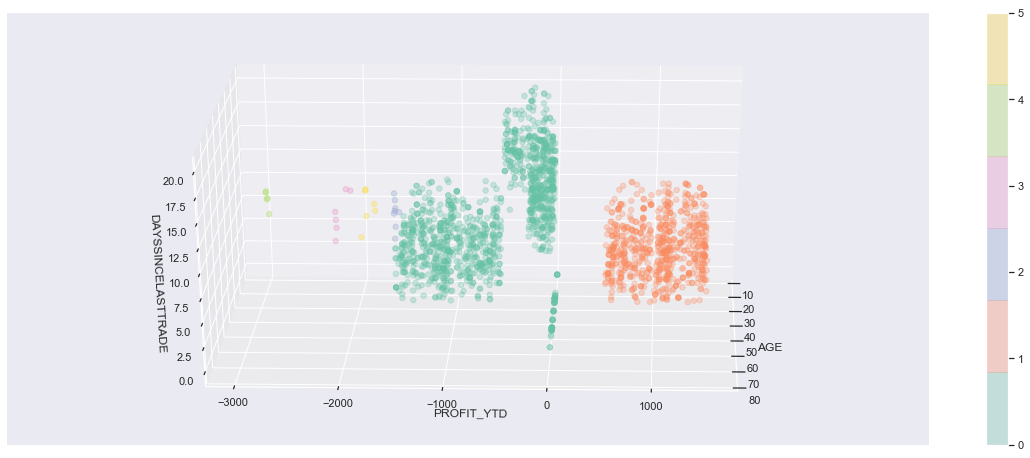

In [38]:
show_scatter_3d(no_outliers_df, x_name, y_name, z_name, predicted=no_outliers_df['CLUSTER'], azim=2);

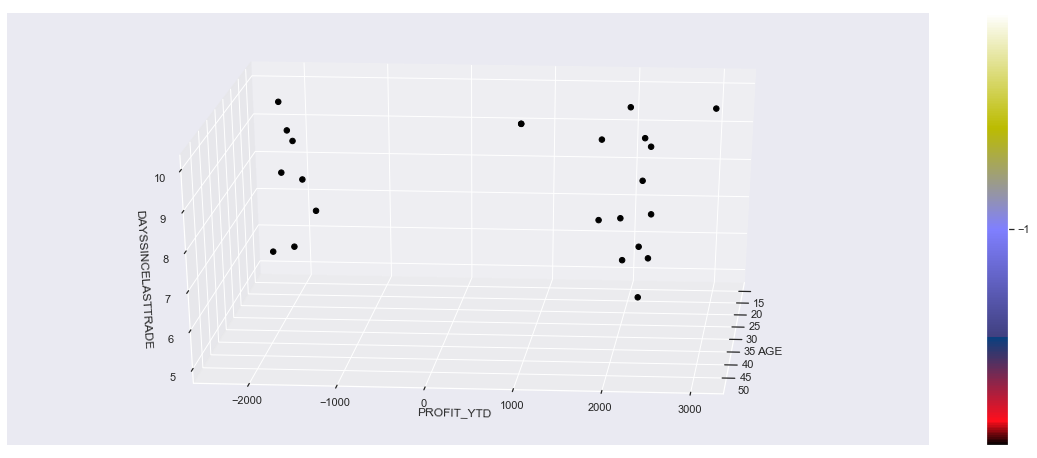

In [39]:
show_scatter_3d(outliers_df, x_name, y_name, z_name, predicted=outliers_df['CLUSTER'], cmap=cm.gist_stern, alpha=1, azim=5);

## Hierarchical Clustering
Hierarchical clustering knows two directions or two approaches. One is bottom-up, and the other is top-down. For bottom-up, each point starts as an individual cluster. Next, the two closest clusters are joined to form a two-point cluster. The process continues to merge the closest clusters until you have a single cluster containing all the points. Top-down is just the opposite. It starts with a single cluster containing all the points and then divides until each cluster is an individual point.

Either way, hierarchical clustering produces a tree of cluster possibilities for n data points. After you have your tree, you pick a level to get your clusters.

#### Agglomerative clustering
Agglomerative clustering is a bottom-up hierarchical clustering algorithm. To pick the level that will be “the answer” you use either the `n_clusters` or `distance_threshold` parameter. We wanted to avoid picking `n_clusters` (because we didn’t like that in k-means), but then we had to adjust the `distance_threshold` until we got a number of clusters that we liked. You can significantly change the results by tweaking the parameters.

One of the interesting things about agglomerative clustering is that you get different cluster sizes. Our customer data demo with agglomerative clustering is interesting because we ended up with 14 clusters of various shapes and sizes.

In [44]:
from sklearn.cluster import AgglomerativeClustering
# ac = AgglomerativeClustering(n_clusters=None,
#                              distance_threshold = 1, affinity='euclidean', linkage='complete')

ac = AgglomerativeClustering(n_clusters=14,
                            affinity='euclidean', linkage='complete')

predicted = ac.fit_predict(df_churn)


print('Number of clusters:', len(set(predicted)))

Number of clusters: 14


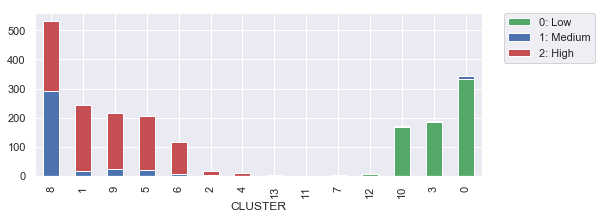

In [45]:
show_risk_by_cluster(predicted, known_risk)

Once again, we see that this works fine to separate our low-risk customers from high-risk. The higher number of clusters appears unnecessary, but does help with finer distinctions in our customer groupings. The smallest clusters look less significant, but they help clarify the other customer groupings.

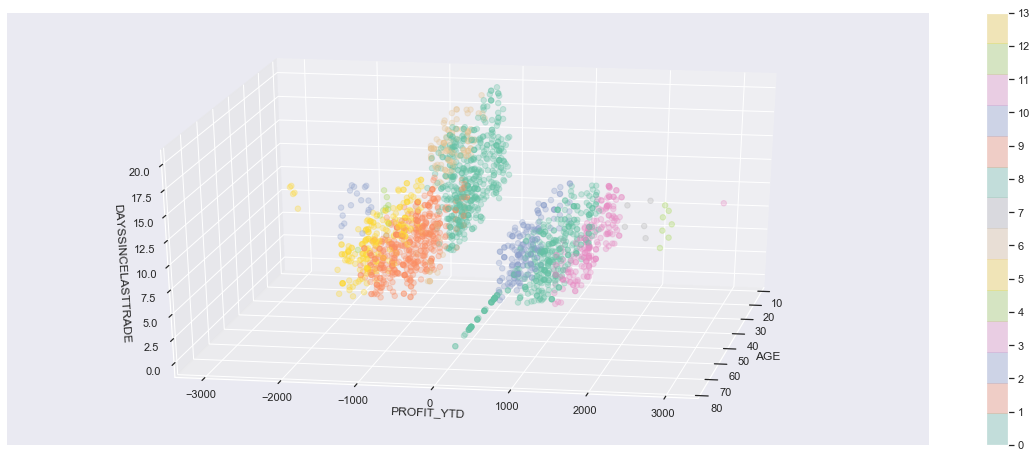

In [46]:
show_scatter_3d(df_churn, x_name, y_name, z_name, predicted=predicted);

In [47]:
X_df = df_churn.copy()
X_df['CLUSTER'] = predicted
plotly_scatter_3d(X_df, x_name, y_name, z_name, color='CLUSTER')

## Use cases
This section gives you some use cases for unsupervised learning.

#### Recommenders
Clustering customers can be used to build recommenders that can:

- Offer a coupon that the customer is likely to appreciate
- Recommend a movie that the customer should like
- Identify a customer as high-risk


#### Uncover hidden features
After clusters have been analyzed and found to exhibit specific behaviors, they can be used to label data as if you had another attribute or feature. We had some data with a churn risk label, but after we pick our best algorithm we can start labeling all of our customers as: low risk, high risk, or medium/high risk.

Another good example would be to use the movie-recommender clusters and just go ahead and label someone as a Romantic-Comedy fan.

The hidden feature idea is that after you understand the behavior of the group, then you have new attributes to infer about the individual. They are not observed attributes, but predicted or inferred. They can still be used much the same way (that is, fed into supervised learning), but only with some probability of accuracy.

Note that we’re not talking about labeling people. We are analyzing data points. Sometimes, they happen to be about people. The next examples are better.

#### Anomaly detection
We tried to point out the benefits of identifying outliers because removing noise helps clarify clusters and anomaly detection is a great use case

As we demonstrated, you can use clustering to identify outliers or anomalies. This strategy can be used to identify unusual behavior that should be investigated further, such as:

- Unusual purchases (credit card fraud)
- Unusual network traffic (denial of service attack)


#### Computer vision
Clustering algorithms are used for image segmentation, object tracking, and image classification. Using pixel attributes as data points, clustering algorithms help identify shapes and textures and turn images into objects that can be recognized with computer vision.